# CaseStudy: EDA on Hotel Demand and Forecast
<p style='text-align: right;'> Author: Shreyas Pandit </p> 


###### 1. Which hotel type received most bookings ?
###### 2. When was a surge observed in bookings ?
###### 3. What type of guests are most expected ?
###### 4. What trend was observed comparing weekdays and weekends ?
###### 5. Which room types got alloted the most ?
###### 6. When were cancellations more frequent ?
###### 7. Was there any impact of room assignment on bookings ?
###### 8. When is the best time to make a booking to get economical rates ?

---
## Data Collection

In [1]:
# import required packages for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# display all columns of dataframe when called
pd.options.display.max_columns = None

# import dataset into data frame
hotels_filepath = "D:\PGDDSS\Python\hotel_bookings.csv"
hotels_dataframe = pd.read_csv(hotels_filepath)

In [2]:
# User defined function to understand dimensions of the data
def get_dataframeDetails(h_df):
    hb_rows,hb_columns = h_df.shape
    print('Total booking records: ',hb_rows)
    print('Total booking attributes: ',hb_columns)
    return h_df.head()

# Call function to display details
get_dataframeDetails(hotels_dataframe)

Total booking records:  119390
Total booking attributes:  32


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


---
## Data Cleaning and Restructuring

In [3]:
# Check for columns containing null values
hotels_dataframe.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
# For columns having data type as object change data type to string 
for column in hotels_dataframe.columns:
    if (hotels_dataframe[column].dtype =='object'):
        hotels_dataframe[column] = hotels_dataframe[column].astype(str)

# Change data type of is_canceled column to boolean
hotels_dataframe['is_canceled'] = hotels_dataframe['is_canceled'].astype(bool)

# substituting null values with 0 in children column
hotels_dataframe['children'] = hotels_dataframe['children'].fillna(0).astype(int)

# removing a series of columns
hotels_dataframe.drop(hotels_dataframe.loc[:,'meal':'previous_bookings_not_canceled'].columns,inplace=True,axis=1)
hotels_dataframe.drop(hotels_dataframe.loc[:,'booking_changes':'company'].columns,inplace=True,axis=1)

# removing specific columns
hotels_dataframe.drop(['lead_time','arrival_date_week_number','required_car_parking_spaces'
                       ,'total_of_special_requests','customer_type'
                       ,'days_in_waiting_list'],inplace=True,axis=1)

#adding new columns in dataframe for future reference
hotels_dataframe['guestType'] = hotels_dataframe.apply(lambda x: 'Family' if(((x['children']!=0) | (x['babies']!=0)) & (x['adults']!=0)) 
                                 else ('Adults' if((x['adults']!=0) & ((x['children']==0) & (x['babies']==0)))
                                    else 'Minors'),axis=1)
hotels_dataframe['room_changed'] = hotels_dataframe.apply(lambda z: 1 
                                    if(z['reserved_room_type']!=z['assigned_room_type']) 
                                    else 0,axis=1)
hotels_dataframe['adr_per_person'] = hotels_dataframe['adr']/(hotels_dataframe['adults']+hotels_dataframe['children']+hotels_dataframe['babies'])

# remove adr values less than or equal to 0
hotels_dataframe = hotels_dataframe.apply(lambda x: x.replace([np.inf, -np.inf], np.nan))
hotels_dataframe['adr_per_person'].dropna(inplace=True)
indexes = hotels_dataframe[hotels_dataframe['adr_per_person']<=0].index
hotels_dataframe.drop(indexes,inplace=True)

# Order months chronologically
order = ['January','February','March','April','May','June','July','August','September','October','November','December']
hotels_dataframe['arrival_date_month'] = pd.Categorical(hotels_dataframe['arrival_date_month'], ordered=True, categories=order)

# getting view of updated dataframe
get_dataframeDetails(hotels_dataframe)

Total booking records:  117579
Total booking attributes:  18


,hotel,is_canceled,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,reserved_room_type,assigned_room_type,adr,reservation_status,reservation_status_date,guestType,room_changed,adr_per_person
2,Resort Hotel,False,2015,July,1,0,1,1,0,0,A,C,75.0,Check-Out,2015-07-02,Adults,1,75.0
3,Resort Hotel,False,2015,July,1,0,1,1,0,0,A,A,75.0,Check-Out,2015-07-02,Adults,0,75.0
4,Resort Hotel,False,2015,July,1,0,2,2,0,0,A,A,98.0,Check-Out,2015-07-03,Adults,0,49.0
5,Resort Hotel,False,2015,July,1,0,2,2,0,0,A,A,98.0,Check-Out,2015-07-03,Adults,0,49.0
6,Resort Hotel,False,2015,July,1,0,2,2,0,0,C,C,107.0,Check-Out,2015-07-03,Adults,0,53.5


---
## Data Visualization

In [5]:
# User defined functions for adding annotations
def annotate_coutplot(chart):
    for bar in chart.patches:
        chart.annotate(format(round(bar.get_height()/1000), '.0f')+'K', 
            (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
            ha = 'center', va = 'center', 
            size=12,
            xytext = (0, -12), color='white',
            textcoords = 'offset points')

Text(0.5, 0, 'Years')

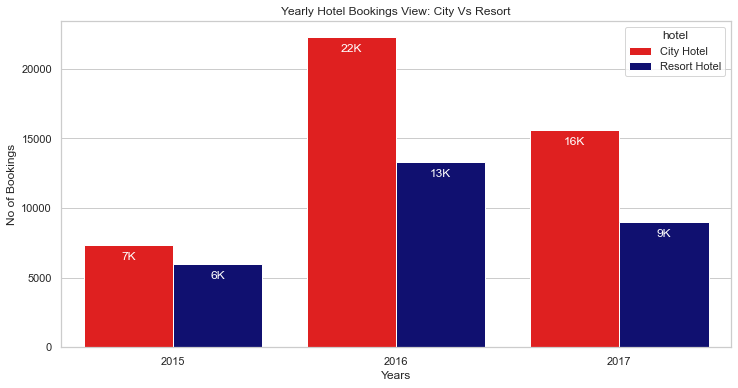

In [6]:
# Plot for yearly bookings view
h_df1 = hotels_dataframe[hotels_dataframe['is_canceled']==False]

sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))

chart = sns.countplot(x='arrival_date_year',hue='hotel',data=h_df1,palette=["Red","Navy"],hue_order=['City Hotel','Resort Hotel'])
annotate_coutplot(chart)
plt.title('Yearly Hotel Bookings View: City Vs Resort')
plt.ylabel('No of Bookings')
plt.xlabel('Years')

---

In [7]:
# Create new data frames
h_df2 = hotels_dataframe[['is_canceled','arrival_date_month','hotel','reservation_status']].copy()
h_monthly_bookings = h_df2[h_df2['is_canceled']==False]
h_monthly_cancellations = h_df2[(h_df2['is_canceled']==True) & (h_df2['reservation_status']!='Check-Out')]
get_dataframeDetails(h_df2)

Total booking records:  117579
Total booking attributes:  4


,is_canceled,arrival_date_month,hotel,reservation_status
2,False,July,Resort Hotel,Check-Out
3,False,July,Resort Hotel,Check-Out
4,False,July,Resort Hotel,Check-Out
5,False,July,Resort Hotel,Check-Out
6,False,July,Resort Hotel,Check-Out


Text(0.5, 0, 'Months')

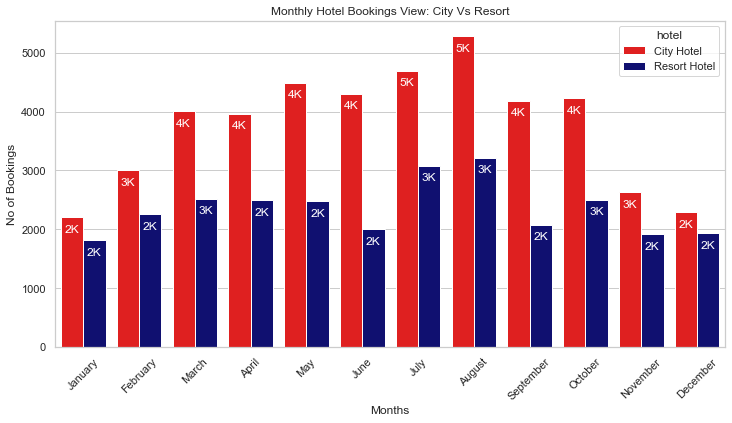

In [8]:
# Plot monthly booking view
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
chart = sns.countplot(x='arrival_date_month',data=h_monthly_bookings,hue='hotel',
              palette=["Red","Navy"],hue_order=['City Hotel','Resort Hotel'])
annotate_coutplot(chart)
plt.title('Monthly Hotel Bookings View: City Vs Resort')
plt.ylabel('No of Bookings')
plt.xticks(rotation=45)
plt.xlabel('Months')

Text(0.5, 0, 'Months')

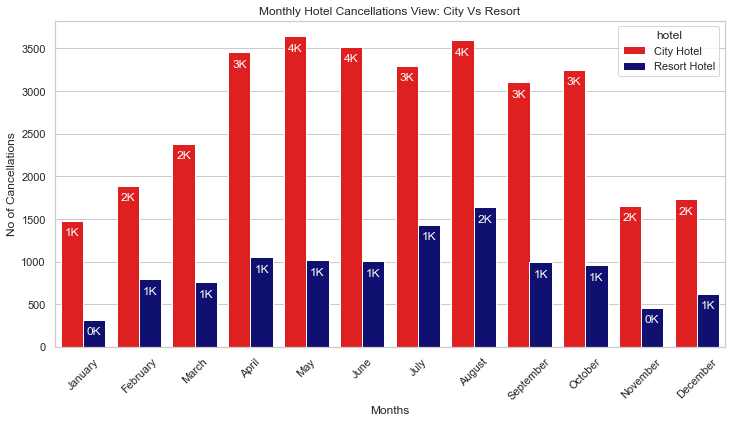

In [9]:
# Plot monthly cancellation view
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
chart = sns.countplot(x='arrival_date_month',data=h_monthly_cancellations,hue='hotel',
              palette=["Red","Navy"],hue_order=['City Hotel','Resort Hotel'])
annotate_coutplot(chart)
plt.title('Monthly Hotel Cancellations View: City Vs Resort')
plt.ylabel('No of Cancellations')
plt.xticks(rotation=45)
plt.xlabel('Months')

---

In [10]:
# Create new dataframe for guest types plotting
h_df3 = hotels_dataframe[['hotel','is_canceled','adults','children','babies','arrival_date_year','guestType']]
h_df3 = h_df3[(h_df3['is_canceled']==False)]
get_dataframeDetails(h_df3)

Total booking records:  73543
Total booking attributes:  7


,hotel,is_canceled,adults,children,babies,arrival_date_year,guestType
2,Resort Hotel,False,1,0,0,2015,Adults
3,Resort Hotel,False,1,0,0,2015,Adults
4,Resort Hotel,False,2,0,0,2015,Adults
5,Resort Hotel,False,2,0,0,2015,Adults
6,Resort Hotel,False,2,0,0,2015,Adults


<Figure size 864x432 with 0 Axes>

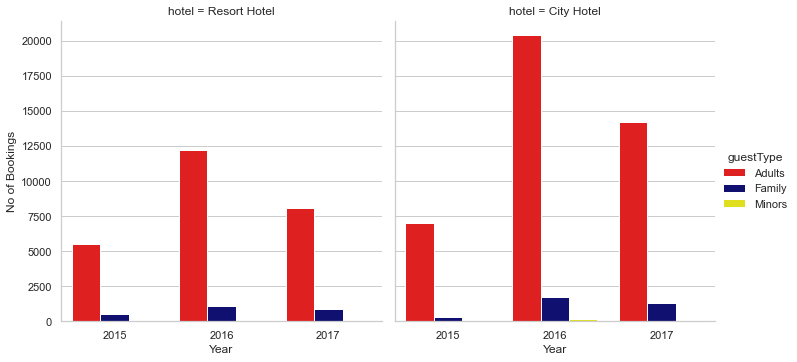

In [11]:
# Plot categorical guest_type booking view
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
chart = sns.catplot(x='arrival_date_year',hue='guestType',col='hotel',data=h_df3,kind="count",
                  palette=["Red","Navy","Yellow"])
chart.set_xlabels('Year')
chart.set_ylabels('No of Bookings')

In [12]:
# Create new dataframe for weekwise plotting
h_df4 = hotels_dataframe[['is_canceled','hotel','arrival_date_month'
                          ,'stays_in_weekend_nights','stays_in_week_nights']]
h_df4 = h_df4[(h_df4['is_canceled']==False)]
get_dataframeDetails(h_df4)

Total booking records:  73543
Total booking attributes:  5


,is_canceled,hotel,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights
2,False,Resort Hotel,July,0,1
3,False,Resort Hotel,July,0,1
4,False,Resort Hotel,July,0,2
5,False,Resort Hotel,July,0,2
6,False,Resort Hotel,July,0,2


Text(0.5, 0, 'Months')

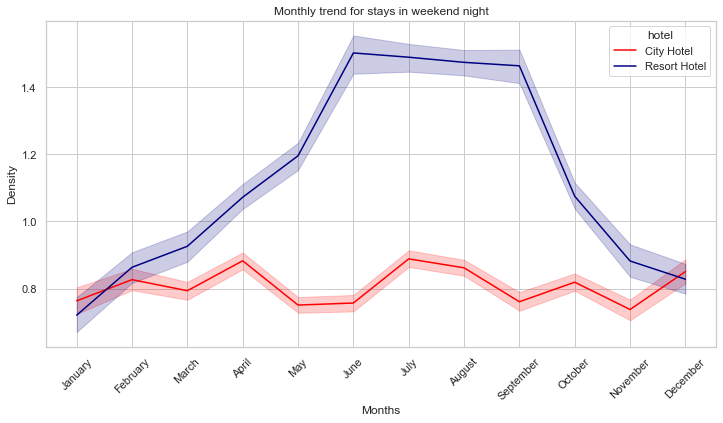

In [13]:
# Plot weekendwise stay trend
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
sns.lineplot(x='arrival_date_month',y='stays_in_weekend_nights',hue='hotel',hue_order=['City Hotel','Resort Hotel'],
             data=h_df4,palette=["Red","Navy"])
plt.title('Monthly trend for stays in weekend night')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.xlabel('Months')


Text(0.5, 0, 'Months')

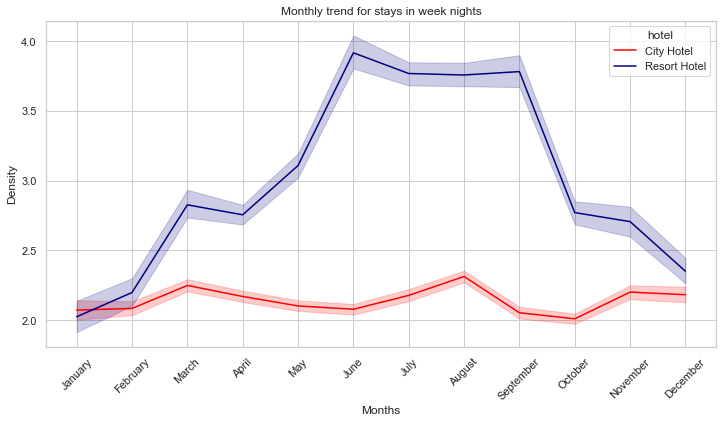

In [14]:
# Plot weekwise stay trend
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
sns.lineplot(x='arrival_date_month',y='stays_in_week_nights',hue='hotel',hue_order=['City Hotel','Resort Hotel'],
             data=h_df4,palette=["Red","Navy"])
plt.title('Monthly trend for stays in week nights')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.xlabel('Months')

---

In [15]:
# Create new dataframe for room type plotting
h_df5 = hotels_dataframe[['is_canceled','hotel','assigned_room_type','adr_per_person']]
h_df5 = h_df5[(h_df5['is_canceled']==False)]
get_dataframeDetails(h_df5)

Total booking records:  73543
Total booking attributes:  4


,is_canceled,hotel,assigned_room_type,adr_per_person
2,False,Resort Hotel,C,75.0
3,False,Resort Hotel,A,75.0
4,False,Resort Hotel,A,49.0
5,False,Resort Hotel,A,49.0
6,False,Resort Hotel,C,53.5


Text(0.5, 0, 'Room Type')

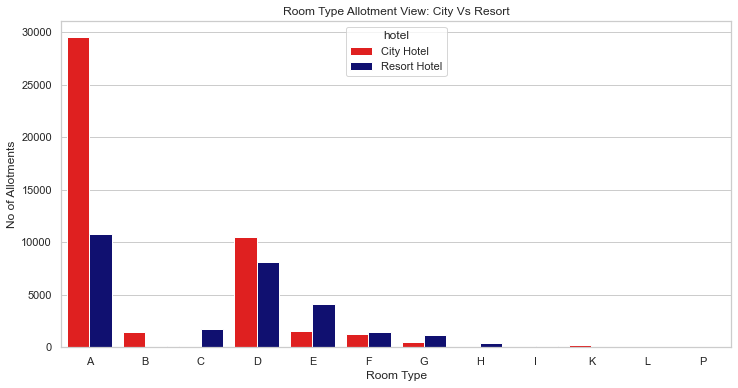

In [16]:
# Plot room type view
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))
chart = sns.countplot(x='assigned_room_type',data=h_df5,hue='hotel',
              order=['A','B','C','D','E','F','G','H','I','K','L','P'],
              palette=["Red","Navy"],hue_order=['City Hotel','Resort Hotel'])
plt.title('Room Type Allotment View: City Vs Resort')
plt.ylabel('No of Allotments')
plt.xlabel('Room Type')

---

In [17]:
# Create new dataframe for average daily rate per person plotting
h_df6 = hotels_dataframe[['is_canceled','hotel','arrival_date_month','adr_per_person']]
h_df6 = h_df6[(h_df6['is_canceled']==False)]

# get months containing lowest adr rates for hotels
lowest_adr_resort = h_df6[h_df6['hotel']=='Resort Hotel'].groupby('arrival_date_month').mean().\
                    sort_values(by='adr_per_person').reset_index().iloc[0]['arrival_date_month']
lowest_adr_city = h_df6[h_df6['hotel']=='City Hotel'].groupby('arrival_date_month').mean().\
                    sort_values(by='adr_per_person').reset_index().iloc[0]['arrival_date_month']
get_dataframeDetails(h_df6)

Total booking records:  73543
Total booking attributes:  4


,is_canceled,hotel,arrival_date_month,adr_per_person
2,False,Resort Hotel,July,75.0
3,False,Resort Hotel,July,75.0
4,False,Resort Hotel,July,49.0
5,False,Resort Hotel,July,49.0
6,False,Resort Hotel,July,53.5


Text(0.5, 0, 'Months')

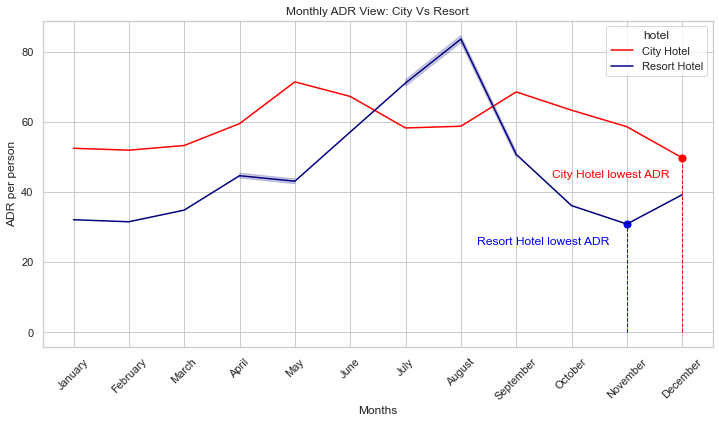

In [18]:
# Plot average daily rate per person view
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12,6))

chart = sns.lineplot(x='arrival_date_month',y='adr_per_person',hue='hotel',hue_order=['City Hotel','Resort Hotel'],data=h_df6,
             palette=["Red","Navy"])
blue_min = chart.lines[1].get_ydata().min()
red_min = chart.lines[0].get_ydata().min()
plt.plot([lowest_adr_resort,lowest_adr_resort], [0, blue_min], color='blue', linewidth=1.0, linestyle="--")
plt.scatter([lowest_adr_resort, ], [blue_min, ], 50, color='blue')
chart.annotate('Resort Hotel lowest ADR',  
            xy=(lowest_adr_resort,blue_min),
            size=12,
            xytext = (-150, -20), color='blue',
            textcoords = 'offset points',
            )
plt.plot([lowest_adr_city,lowest_adr_city], [0, red_min], color='red', linewidth=1.0, linestyle="--")
plt.scatter([lowest_adr_city, ], [red_min, ], 50, color='red')
chart.annotate('City Hotel lowest ADR',  
            xy=(lowest_adr_city,red_min),
            size=12,
            xytext = (-130, -20), color='red',
            textcoords = 'offset points',
            )

plt.title('Monthly ADR View: City Vs Resort')
plt.ylabel('ADR per person')
plt.xticks(rotation=45)
plt.xlabel('Months')

---

In [19]:
# User Defined Function
def yules_coeff(h_df7):
    """Returns association value after calculating Yules coefficient of association
       Dataframe is passed as argument
       Possible return values:
       Between -1.00 and 0.00 -> 'negatively associated'
       Between  0.00 and 1.00 -> 'positvely associated'
       0.00 -> 'not associated but independent'
    """
    A = h_df7[h_df7['is_canceled']==True].shape[0]
    a = h_df7[h_df7['is_canceled']==False].shape[0]
    B = h_df7[h_df7['room_changed']==1].shape[0]
    b = h_df7[h_df7['room_changed']==0].shape[0]
    
    Q = ((A*B)*(a*b)-(A*b)*(a*B))/((A*B)*(a*b)+(A*b)*(a*B))
    
    if(Q<0):
        return 'negatively associated'
    elif(Q>0):
        return 'positvely associated'
    else:
        return 'not associated but independent'

# Create new dataframe
h_df7 = hotels_dataframe[['is_canceled','room_changed']]

# Call for yule's coefficient check
association_val = yules_coeff(h_df7)
print("Association value by Yule's indicates that the attributes are",association_val)


Association value by Yule's indicates that the attributes are not associated but independent


---

## Summarizing Findings

###### From the given data following observations can be summarized: 
###### 1. City Hotel received most bookings in a year.
###### 2. Typically a surge in bookings was observed in the month of August.
###### 3. Adults without children are most expected.
###### 4. Stays in Resort were high between June and September whereas stays in City hotel were high between July and August.
###### 5. Room Type A was most allocated followed by Room Type D.
###### 6. Cancellations were high in May and August for City hotel and high in July for Resort.
###### 7. Room assignment has no impact on bookings.
###### 8. Booking rates are low in December and January for City Hotel and low in November and February for Resort.

---